In [46]:
%load_ext autoreload
%autoreload 2

import os
import sys

# from  GRU import GRUEncoderGD, GRUDecoderGD
# from TPDN import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torchmetrics.classification import Accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles

# def precision(predicted, target):
#     correct = (predicted.argmax(dim=-1) == target).float()
#     return correct.mean().item() * 100

def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')
    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
class GRUEncoderGD(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, emb_size)
        self.rnn = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=self.num_layers)


    def forward(self, sequence):
        embedded = self.embedding(sequence)  # (batch_size, seq_len, emb_size)
        output, hidden = self.rnn(embedded)  # hidden contient le dernier état caché et output la suite de tous les états cachés
        # hidden : num_layers x batchsize x emb_size
        return output, hidden

class GRUDecoderGD(nn.Module):
    def __init__(self, emb_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True, num_layers=self.num_layers)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, hidden, output_len):
        """
        hidden : Dernier état caché de l'encodeur (num_layers, batch_size, hidden_dim).
        """
        batch_size = hidden.size(1)
        outputs = []
        input_t = torch.zeros(batch_size, 1, self.hidden_size).to(self.device)  # entrée initiale
        for _ in range(output_len):
            output, hidden = self.rnn(input_t, hidden)
            output = self.out(output)  # (batch_size, 1, output_size)
            output = self.softmax(output)
            outputs.append(output.squeeze(1))  # (batch_size, output_size)
        return torch.stack(outputs, dim=1)  # (batch_size, seq_len, output_size)


In [26]:
class TensorProductEncoder(nn.Module):
    def __init__(self, n_roles, n_fillers, filler_dim, role_dim, hidden_size):
        super().__init__()

        self.n_roles = n_roles
        self.n_fillers = n_fillers
        self.filler_dim = filler_dim  # dimension des embeddings des fillers
        self.role_dim = role_dim  # dimension des embeddings des rôles

        self.hidden_size = hidden_size  # taille du vecteur caché final

        # Embedding pour les fillers et les rôles
        self.filler_embedding = nn.Embedding(self.n_fillers, self.filler_dim)
        self.role_embedding = nn.Embedding(self.n_roles, self.role_dim)

        # Couche linéaire pour adapter la sortie du produit tensoriel à la taille cachée attendue
        self.last_layer = nn.Linear(self.filler_dim * self.role_dim, self.hidden_size)

    def forward(self, filler_list, role_list):
        fillers_embedded = self.filler_embedding(filler_list)  # (batch_size, seq_len, filler_dim)
        roles_embedded = self.role_embedding(role_list)  # (batch_size, seq_len, role_dim)

        #  stocker les différentes sorties 
        batch_size = fillers_embedded.size(0)
        seq_len = fillers_embedded.size(1)
        final_states = torch.zeros(batch_size, seq_len, self.hidden_size)



        for i in range(fillers_embedded.size(1)):  # itérer sur chaque élément de la séquence
 
            fillers_expanded = fillers_embedded[:, i].unsqueeze(-1)  # (batch_size, filler_dim, 1)
            roles_expanded = roles_embedded[:, i].unsqueeze(-2)  # (batch_size, 1, role_dim)
            
            tensor_product = torch.matmul(fillers_expanded, roles_expanded)  # (batch_size, filler_dim, role_dim)
            

            tensor_product_flattened = tensor_product.view(tensor_product.size(0), -1)  # (batch_size, filler_dim * role_dim)
            

            final_state = self.last_layer(tensor_product_flattened)  # (batch_size, hidden_size)
            
     
            final_states[:, i, :] = final_state

        # final_states est maintenant une liste des états finaux pour chaque étape
        # Le dernier élément est l'état final correspondant à la séquence complète
        return final_states


In [52]:
input_size = 10
emb_size = 5
hidden_size = 32

output_size = 10
num_layers = 2
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

encoder = torch.load( "gru_enc.pth").to(device)
decoder = torch.load( "gru_dec.pth").to(device)

tpdnencoder = torch.load( "tpdn_gru.pth").to(device)

/tmp/ipykernel_4627/1302287238.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder = torch.load( "gru_enc.pth").to(device)
/tmp/ipykernel_4627/1302287238.py:17: Fut

torch.Size([1, 10, 32])
torch.Size([2, 1, 32])
torch.Size([1, 32])
torch.Size([1, 10, 32])
tensor([[-2.9050e-01,  2.9954e-04,  5.2818e-01, -2.5249e-01,  9.9394e-01,
         -8.4947e-01,  2.5148e-01, -3.3101e-01, -8.5398e-02, -1.1100e-01,
         -9.9979e-01, -2.1711e-01,  1.6510e-01,  6.5737e-01,  9.0666e-01,
         -3.9660e-01, -6.2180e-01, -9.9924e-01, -8.5406e-01, -6.6412e-01,
         -5.0957e-01,  9.9983e-01, -2.3933e-01, -2.0456e-01, -2.6587e-01,
          2.3289e-01,  3.5634e-01,  3.7482e-01, -2.9061e-01,  3.8111e-01,
          4.1283e-01, -2.1260e-01]], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([[-0.1400,  0.2355,  0.5702, -0.5921,  1.0055, -0.2986,  0.1536, -0.2353,
         -0.0722, -0.3234, -1.0077, -0.2106,  0.1983,  0.7969,  0.7338,  0.0315,
         -0.3479, -1.0053, -0.2016, -0.2996, -0.3580,  1.0055, -0.5127, -0.3919,
         -0.1908,  0.0425,  0.4649,  0.2166,  0.2381,  0.1858,  0.1170,  0.0493]],
       grad_fn=<SliceBackward0>)


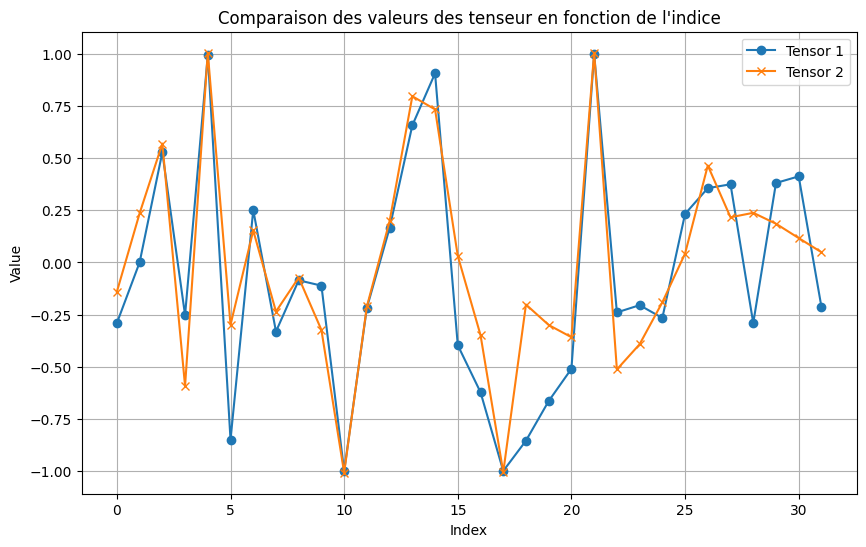

In [49]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
rnn_out, rnn_hidden = encoder(data)
tpdn_output= tpdnencoder(data, roles)
# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:]

print( rnn_out.shape)
print(rnn_hidden.shape)
print(tpdn_hidden.shape)
print(tpdn_output.shape)

print(rnn_hidden[-1])
print(tpdn_hidden)
plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

In [55]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
print(data)

rnn_out, rnn_hidden = encoder(data)
rnn_hidden = rnn_hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1)
tpdn_output= tpdnencoder(data, roles)

# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:].repeat(num_layers, 1, 1).to(device)
# encoder_hidden = rnn_hidden[-1,:,:]
# print( rnn_hidden.shape)
# print(tpdn_hidden.shape)
print()
print(decoder(rnn_hidden, seq_len).argmax(dim=-1).shape)
print(data.shape)
print(decoder(rnn_hidden, seq_len).argmax(dim=-1))
# print(decoder(rnn_hidden, seq_len).view(-1, output_size))
print(decoder(tpdn_hidden, seq_len).argmax(dim=-1))

print( precision(decoder(rnn_hidden, seq_len).argmax(dim=-1),data))

print( precision(decoder(tpdn_hidden, seq_len).argmax(dim=-1),data))

tensor([[0, 5, 6, 0, 0, 0, 7, 4, 3, 8]], device='cuda:0')

torch.Size([1, 10])
torch.Size([1, 10])
tensor([[0, 0, 0, 0, 0, 0, 7, 4, 3, 8]], device='cuda:0')
tensor([[5, 4, 4, 8, 0, 4, 5, 5, 5, 8]], device='cuda:0')
tensor(0.8000, device='cuda:0')
tensor(0.2000, device='cuda:0')


In [51]:
from torchmetrics.classification import Accuracy

# Initialisation de la métrique d'accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=10).to(device)  # Adapte `num_classes` à ton cas


# Calcul de l'accuracy
accuracy = accuracy_fn(decoder(rnn_hidden, seq_len).argmax(dim=-1).to(device),data.to(device))
print(decoder(rnn_hidden, seq_len).argmax(dim=-1))
print(data)
print(f"Accuracy: {accuracy.item() * 100:.2f}%")

tensor([[9, 5, 4, 6, 0, 6, 3, 3, 7, 0]], device='cuda:0')
tensor([[9, 5, 4, 6, 0, 6, 8, 6, 7, 0]], device='cuda:0')
Accuracy: 80.00%
